In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cluster import distance_values
from Bio import SeqIO
from Bio import Phylo
from showHOR import show_hor, show_hors, show_hor_tree
from featureUtils import BED_file_to_features, feature_to_seq
from parallel_distance import build_seqs_distance_matrix_by_chunks, FileSystemChunkStore
from hor import hor_tree_to_phylogeny
from hor_tree import phylogeny_to_hor_tree
from Bio.Phylo.PhyloXML import Phyloxml
from Bio.Phylo import PhyloXMLIO
from clustering_to_phylogeny import clustering_to_phylogeny



In [2]:
references = {seq.id : seq for seq in SeqIO.parse("./data/monomers/chr2_centromere_plus2Mb.fasta", "fasta")}

In [3]:
monomers_as_features = BED_file_to_features("./data/monomers/chr2_StringDecMon2extr_noMorgante.bed")

In [4]:
# sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 60
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [5]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [6]:
monomer_dists = build_seqs_distance_matrix_by_chunks(monomers_as_seqs, num_chunks=32, chunk_store=FileSystemChunkStore("data/submatrices_32/piece_{row}_{col}"))

# of chunks for computing distance matrix: 32
Chunk size: 223
Num processes: 512
Blocks: ['([0:1](223,223))', '([0:2](223,223))', '([1:2](223,223))', '([0:3](223,223))', '([1:3](223,223))', '([2:3](223,223))', '([0:4](223,223))', '([1:4](223,223))', '([2:4](223,223))', '([3:4](223,223))', '([0:5](223,223))', '([1:5](223,223))', '([2:5](223,223))', '([3:5](223,223))', '([4:5](223,223))', '([0:6](223,223))', '([1:6](223,223))', '([2:6](223,223))', '([3:6](223,223))', '([4:6](223,223))', '([5:6](223,223))', '([0:7](223,223))', '([1:7](223,223))', '([2:7](223,223))', '([3:7](223,223))', '([4:7](223,223))', '([5:7](223,223))', '([6:7](223,223))', '([0:8](223,223))', '([1:8](223,223))', '([2:8](223,223))', '([3:8](223,223))', '([4:8](223,223))', '([5:8](223,223))', '([6:8](223,223))', '([7:8](223,223))', '([0:9](223,223))', '([1:9](223,223))', '([2:9](223,223))', '([3:9](223,223))', '([4:9](223,223))', '([5:9](223,223))', '([6:9](223,223))', '([7:9](223,223))', '([8:9](223,223))', '([0:10](2

In [7]:
with open('data/distances.npy', 'wb') as f:
    np.save(f, monomer_dists)

(array([2.186400e+04, 3.680900e+04, 4.914200e+04, 6.673100e+04,
        8.968700e+04, 1.180140e+05, 1.502440e+05, 1.881710e+05,
        2.409830e+05, 3.039120e+05, 3.703790e+05, 4.451380e+05,
        5.183620e+05, 5.891260e+05, 6.418740e+05, 6.806570e+05,
        6.685190e+05, 6.367270e+05, 5.662620e+05, 4.858900e+05,
        4.007310e+05, 3.190660e+05, 2.467160e+05, 1.897630e+05,
        1.521990e+05, 1.253520e+05, 1.215620e+05, 1.374230e+05,
        1.755000e+05, 2.287040e+05, 2.800760e+05, 3.241400e+05,
        3.584810e+05, 3.926610e+05, 4.069210e+05, 4.368090e+05,
        5.208560e+05, 7.332940e+05, 1.036467e+06, 1.350784e+06,
        1.588932e+06, 1.662870e+06, 1.567971e+06, 1.371135e+06,
        1.100390e+06, 8.425870e+05, 6.225740e+05, 4.614420e+05,
        3.224860e+05, 2.164030e+05, 1.535340e+05, 1.064860e+05,
        7.475100e+04, 5.393300e+04, 4.166100e+04, 3.750600e+04,
        3.859000e+04, 4.003300e+04, 3.826300e+04, 3.338300e+04,
        2.443200e+04, 1.623800e+04, 8.96

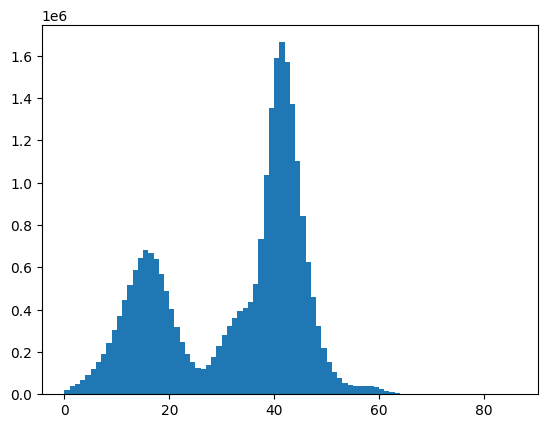

In [8]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))


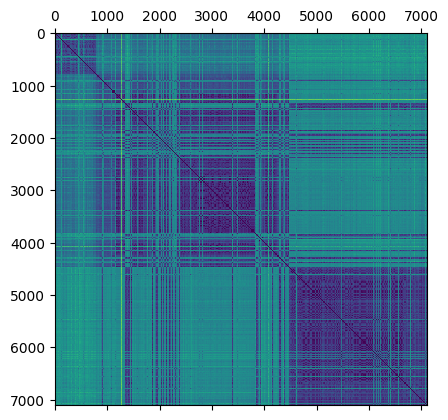

In [9]:
plt.matshow(monomer_dists)

In [10]:
clustering_res = clustering_to_phylogeny(
    dist_matrix=monomer_dists,
    items_as_seq_features=monomers_as_features,
    seq_references=references
)
phylogeny = clustering_res.phylogeny

In [11]:
phyloXml = Phyloxml(phylogenies=[phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, 'data/monomer_phylogeny.xml')

1

In [12]:
hor_tree_root = phylogeny_to_hor_tree(phylogeny, min_loops=5)

In [13]:
hor_phylogeny = hor_tree_to_phylogeny(hor_tree_root)

/Users/miguel/git/dna-repeat-discovery/env/lib/python3.11/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [14]:
phyloXml = Phyloxml(phylogenies=[hor_phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, 'data/HORs.xml')

1

In [15]:
phyloXml = Phyloxml(phylogenies=[phylogeny, hor_phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, 'data/monomer_phylogeny_and_HORs.xml')

2

Subtree: []
None


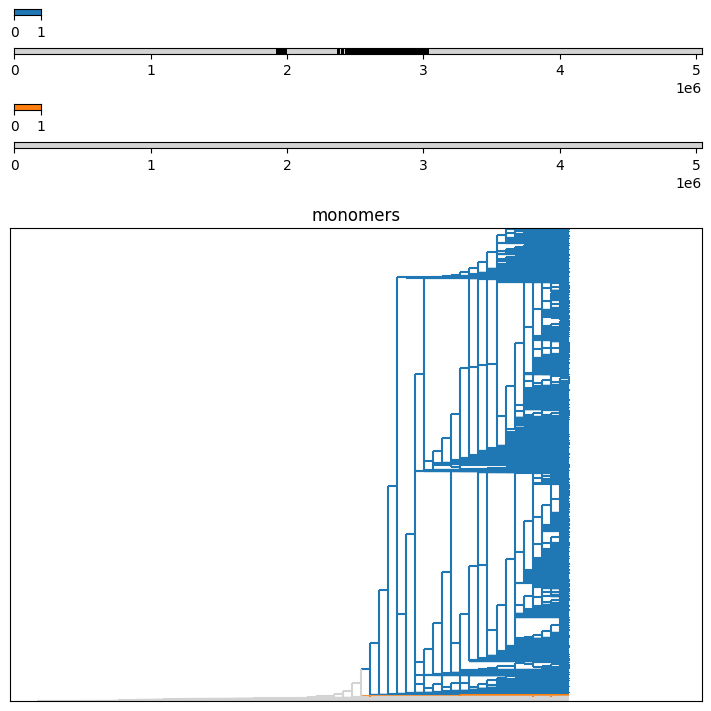

Subtree: [1]
None


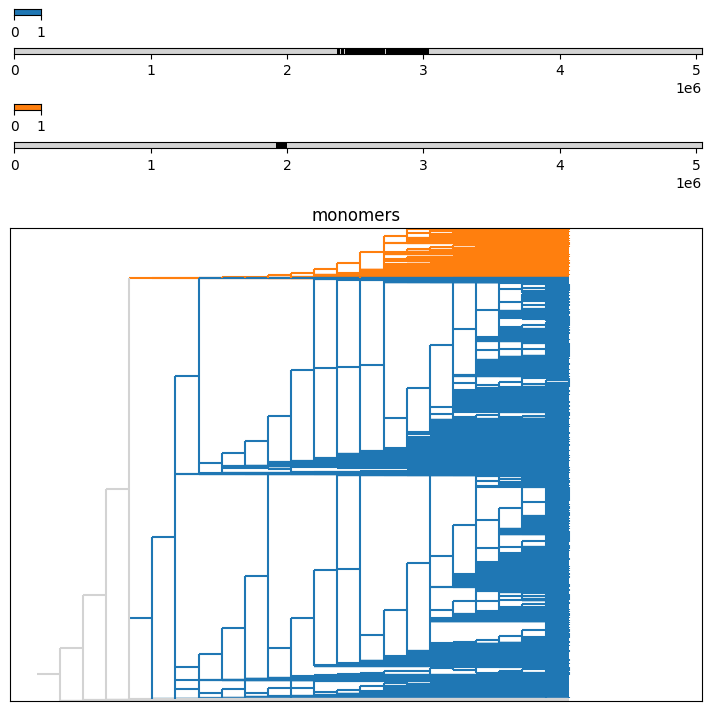

Subtree: [1, 1]
None


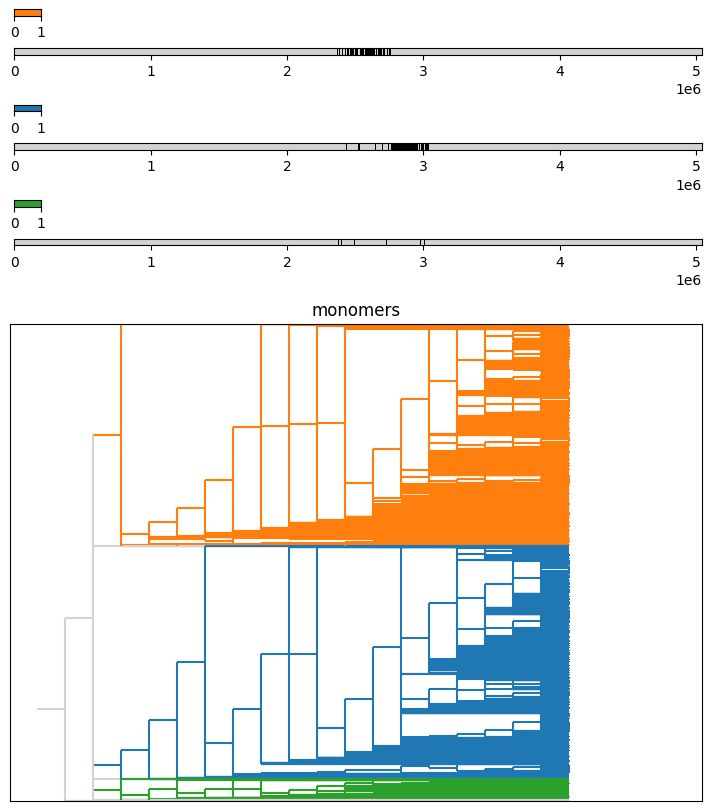

Subtree: [1, 1, 1]
None


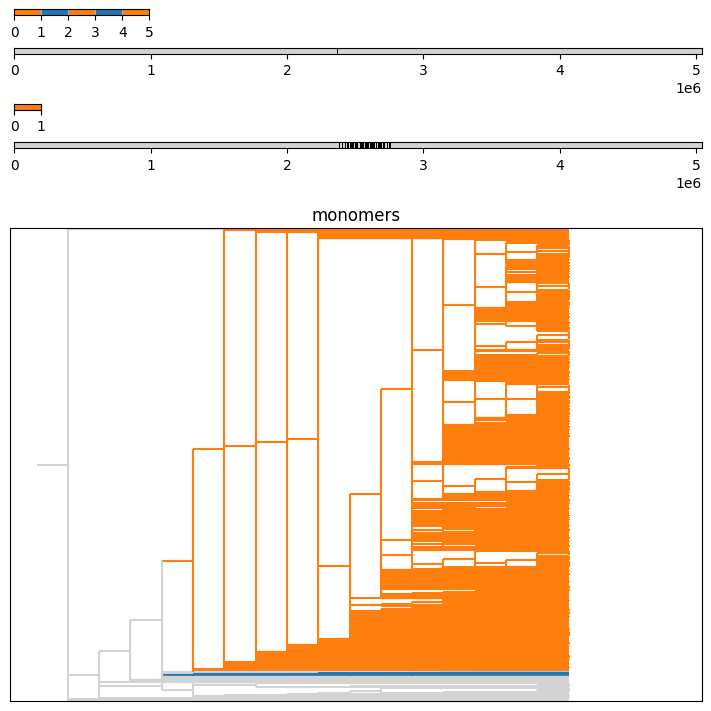

Subtree: [1, 1, 1, 1]
None


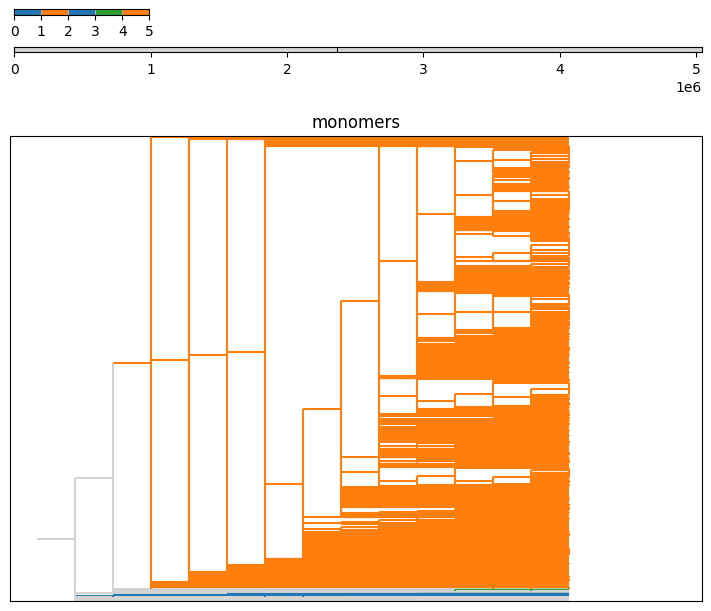

Subtree: [1, 1, 1, 1, 1]
None


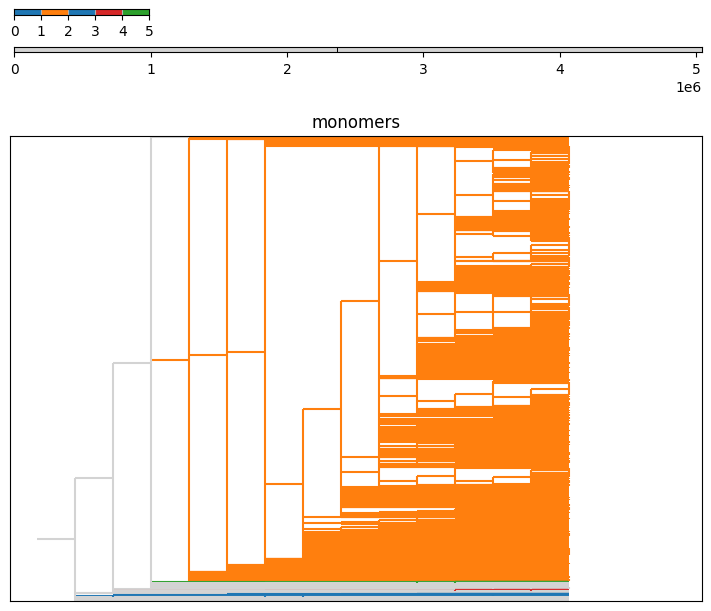

Subtree: [1, 1, 1, 1, 1, 1]
None


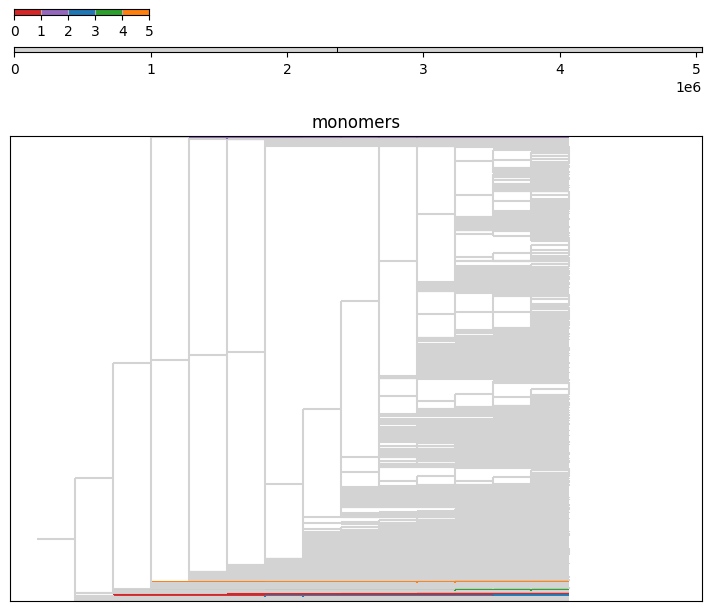

Subtree: [1, 1, 1, 2]
None


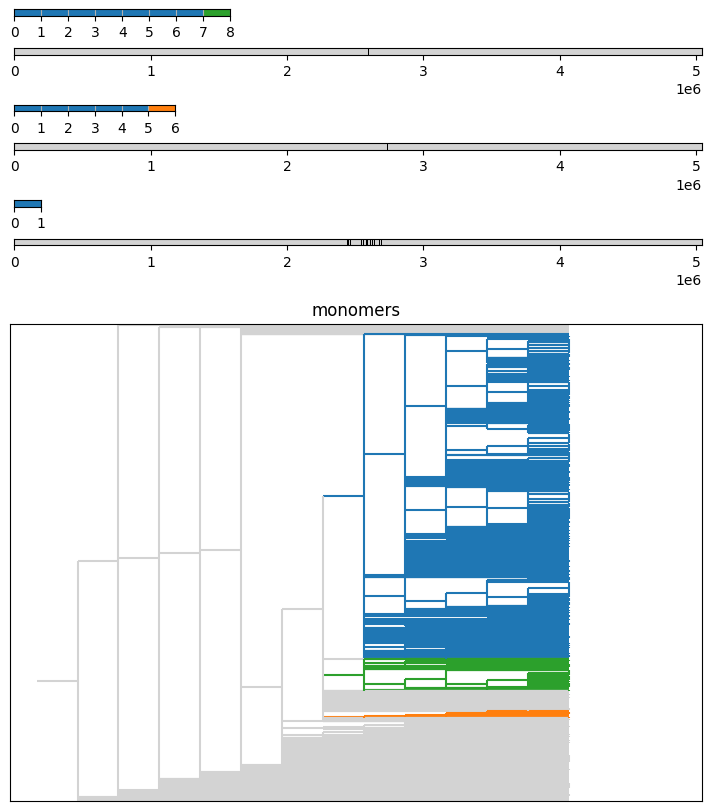

Subtree: [1, 1, 1, 2, 1]
None


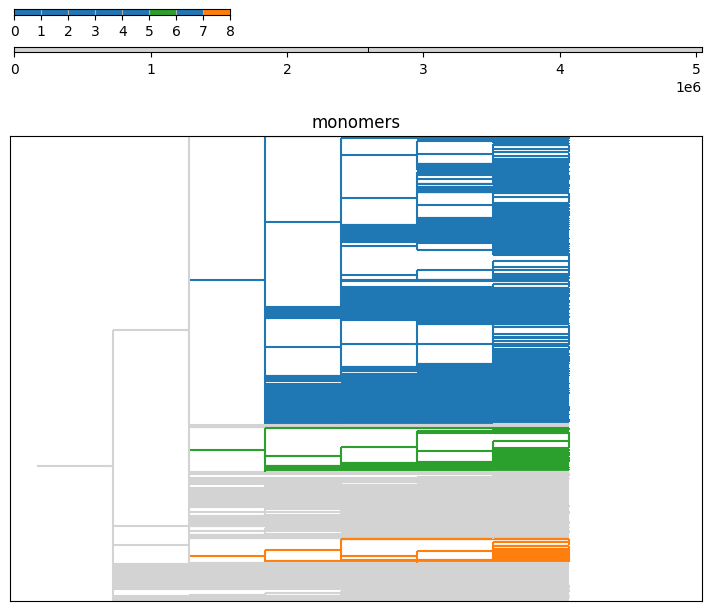

Subtree: [1, 1, 1, 2, 1, 1]
None


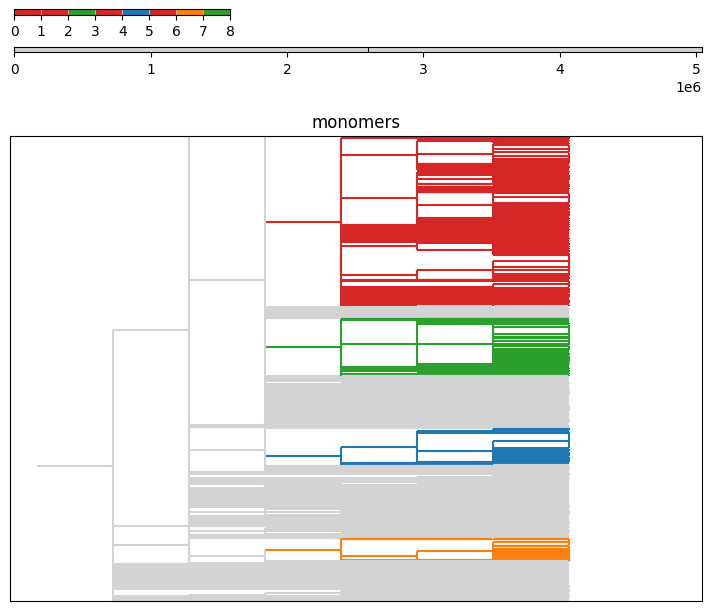

Subtree: [1, 1, 1, 2, 2]
None


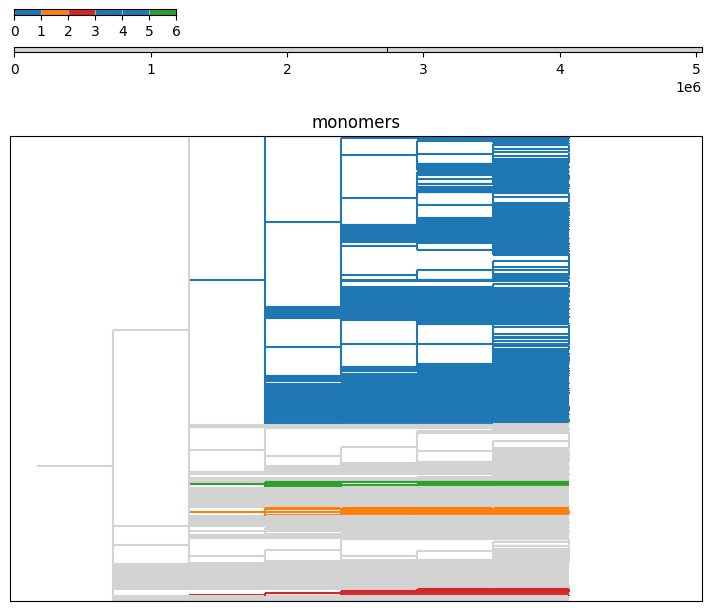

Subtree: [1, 1, 1, 2, 2, 1]
None


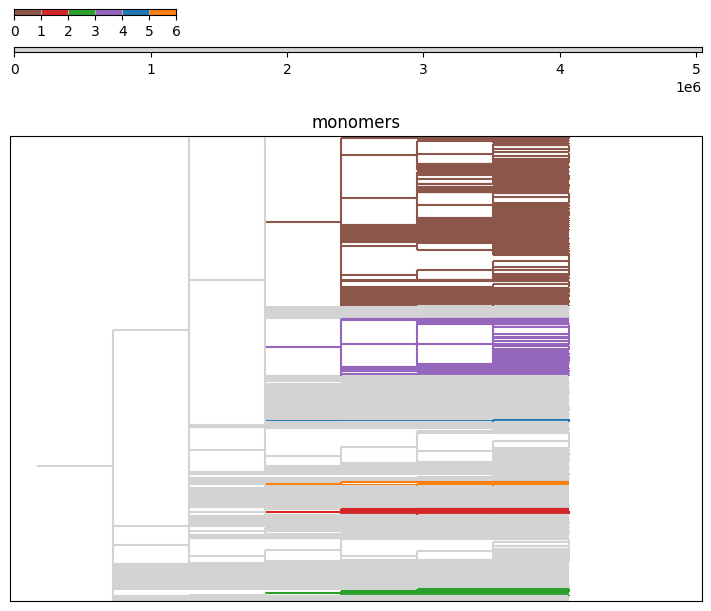

Subtree: [1, 1, 2]
None


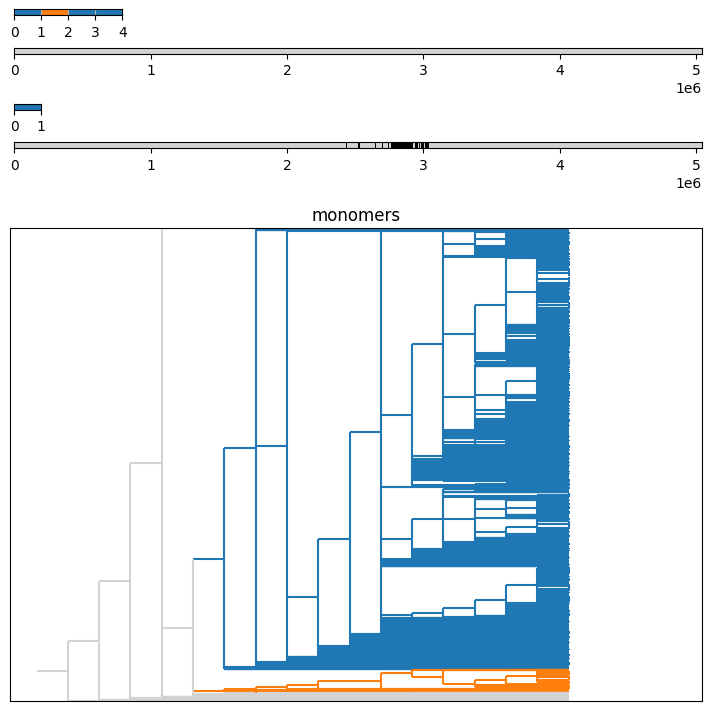

Subtree: [1, 1, 2, 1]
None


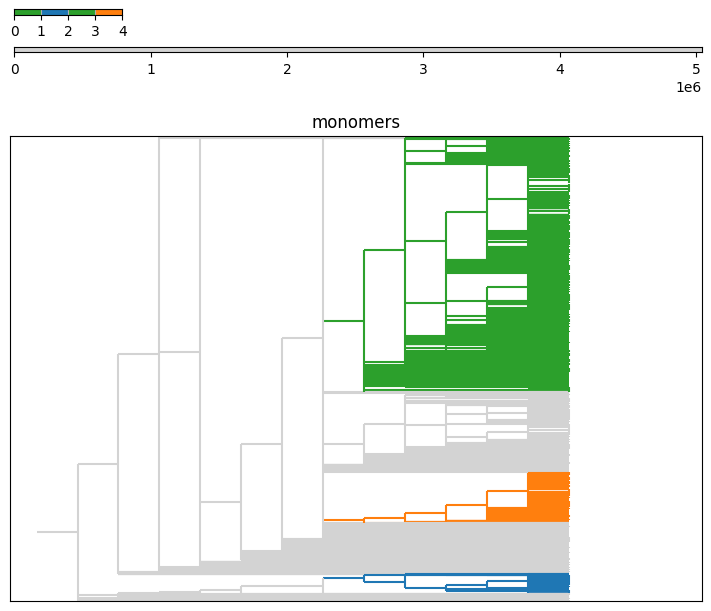

Subtree: [1, 1, 2, 2]
None


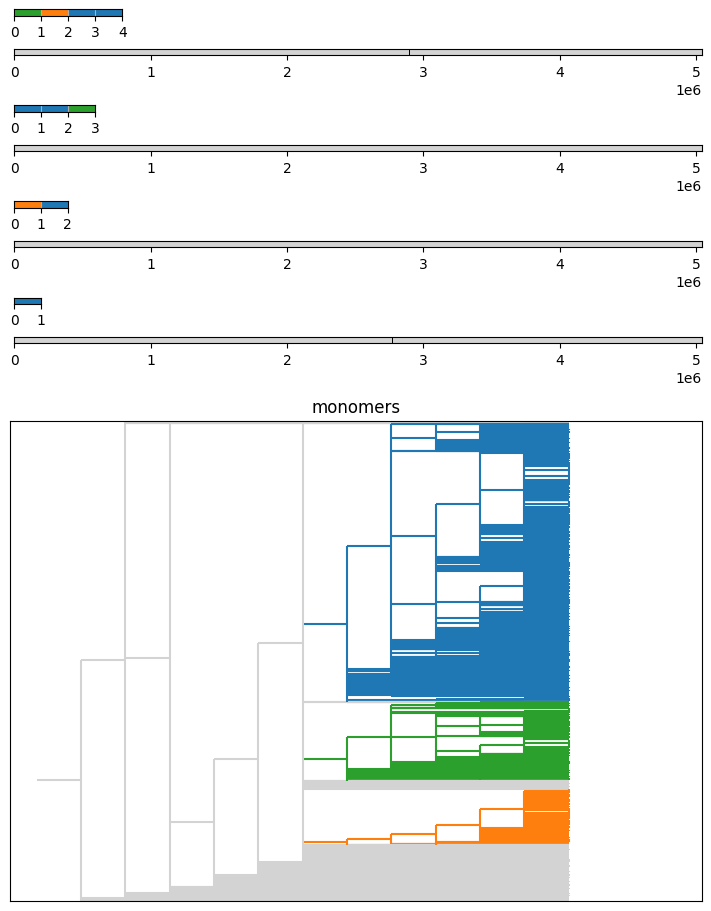

Subtree: [1, 1, 2, 2, 1]
None


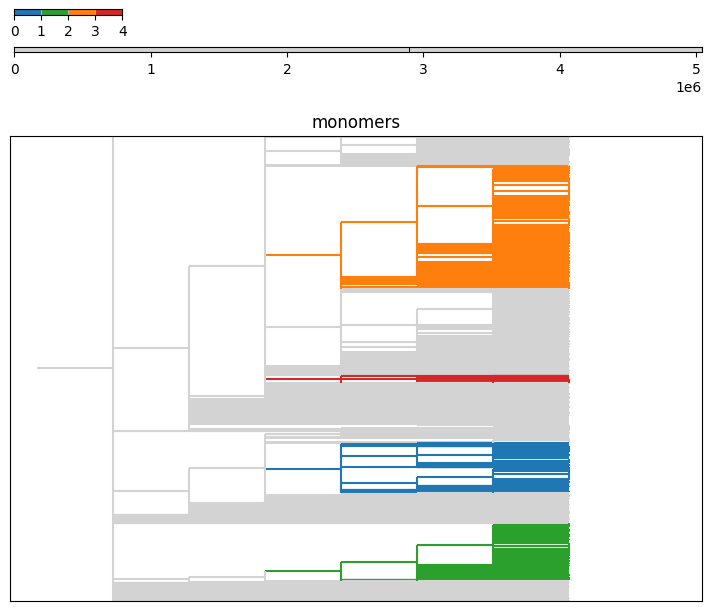

Subtree: [1, 1, 2, 2, 2]
None


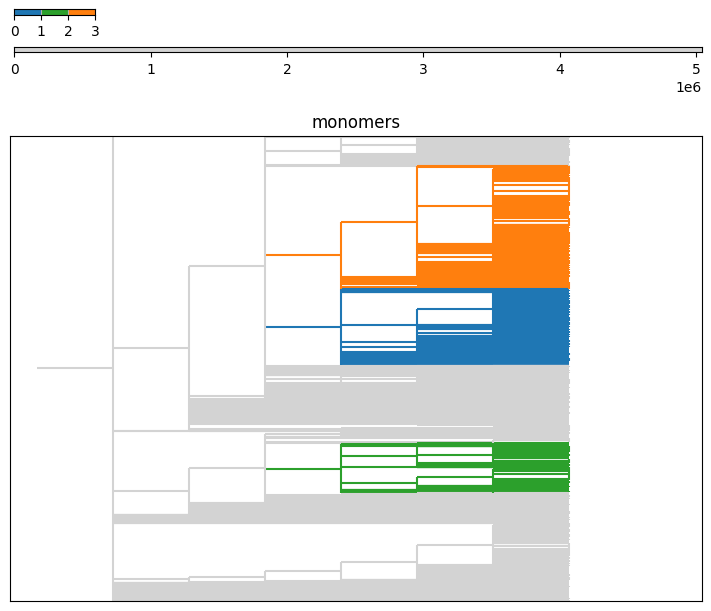

Subtree: [1, 2]
None


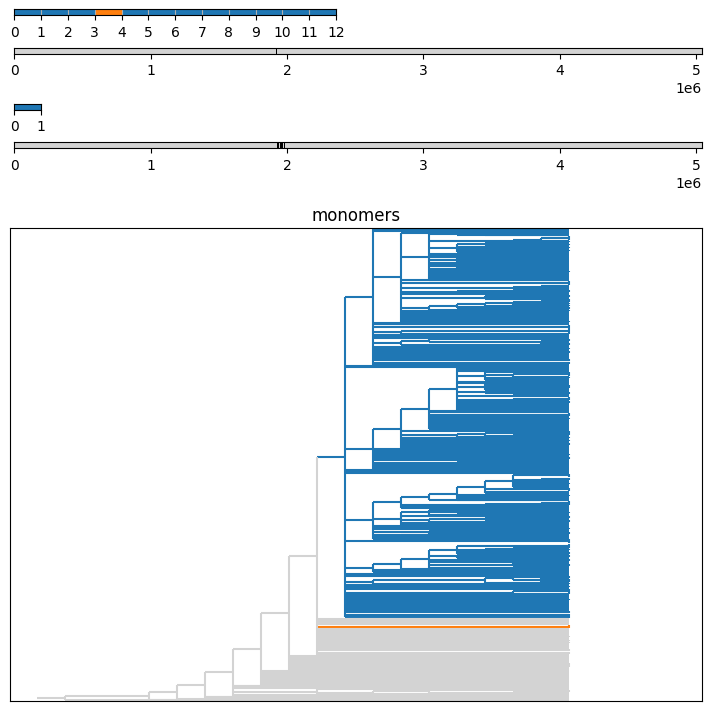

Subtree: [1, 2, 1]
None


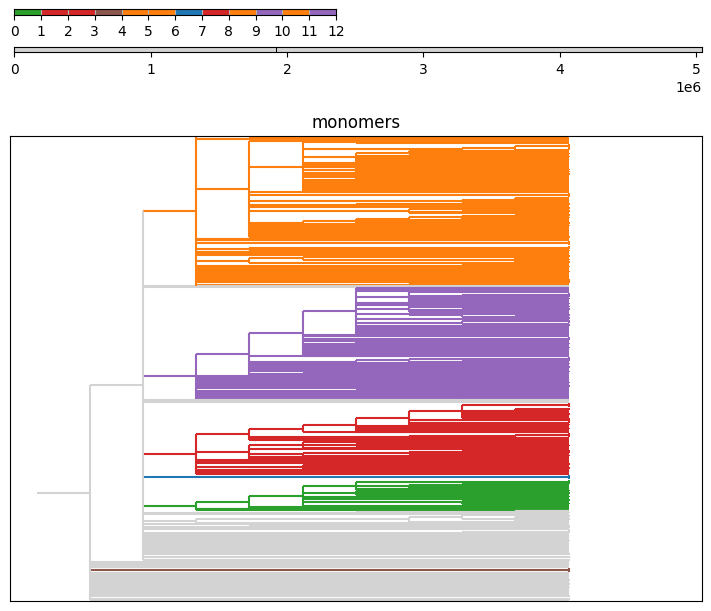

Subtree: [1, 2, 1, 1]
None


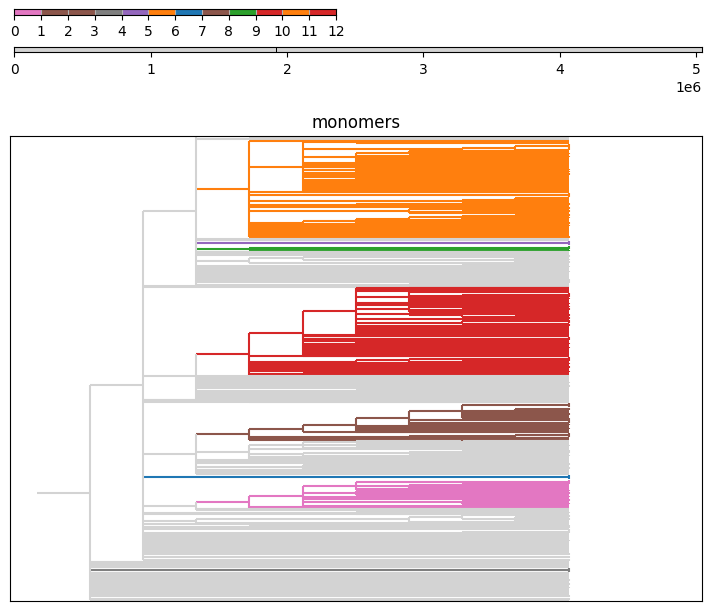

Subtree: [1, 2, 1, 1, 1]
None


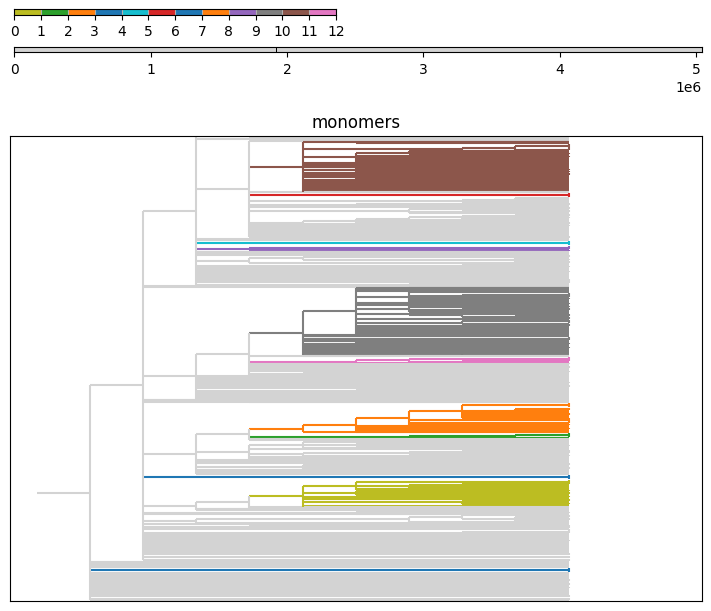

Subtree: [1, 2, 1, 1, 1, 1]
None


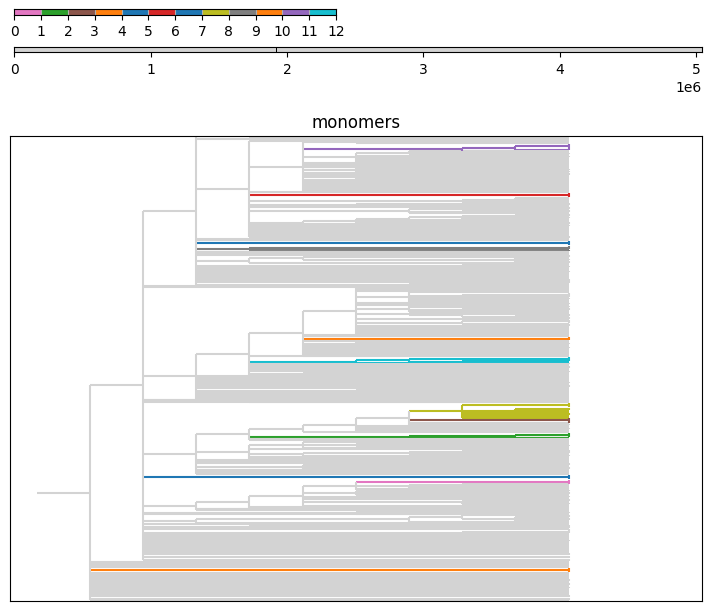

Subtree: [1, 2, 2]
None


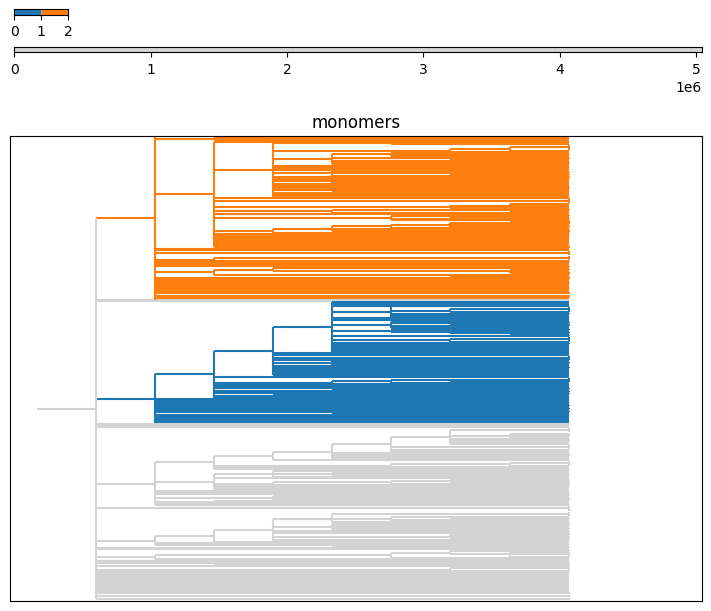

In [16]:
show_hor_tree(hor_tree_root=hor_tree_root, reference_seq=references['chr2:10940332-15983263'], tree=phylogeny)